In [1]:
# auto-reload modules
%load_ext autoreload
%autoreload 2

In [2]:
from Value import *

In [23]:
a = Value(2)
b = Value(3)

c = a + b
c.zero_grad()
c.backward()
c.grad, a.grad, b.grad      # expected: 1, 1, 1

(array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32))

In [24]:
d = a * b
d.zero_grad()
d.backward()
d.grad, a.grad, b.grad      # expected: 1, 3, 2

(array(1., dtype=float32), array(3., dtype=float32), array(2., dtype=float32))

In [25]:
e = Value(-8)
f = e.relu()
f.zero_grad()
f.backward()
f.grad, e.grad          # expected: 1, 0

(array(1., dtype=float32), array(0., dtype=float32))

In [18]:
g = Value([[-1, 5]])
gl0 = g.cross_entropy_loss([0])
gl0.zero_grad()
gl0.backward()
gl0.value, gl0.grad, g.grad

(array(6.0024757, dtype=float32),
 array(1., dtype=float32),
 array([[-0.99752736,  0.9975274 ]], dtype=float32))

In [17]:
gl1 = g.cross_entropy_loss([1])
gl1.zero_grad()
gl1.backward()
print(gl1.value)
print(g.grad)
g.value -= g.grad
gl1 = g.cross_entropy_loss([1])
print(gl1.value)        # gl1 value should be decreased

0.0024635117
[[ 0.00246046 -0.00246048]]
0.002451442


In [16]:
h = a + b       # a = 2, b = 3
i = h * b + a * b
i.zero_grad()
i.backward()
print(h.grad)   # expected: b * di = 3 * 1 = 3
print(b.grad)   # expected: (h + a) * di + dh = (5 + 2) * 1 + 3 = 10
print(a.grad)   # expected: b * di + dh = 3 + 3 = 6

3.0
10.0
6.0


In [26]:
A = Value(np.array([
    [1, 2],
    [3, 4]
]))
B = Value(np.array([
    [5, 6],
    [7, 8]
]))
C = A.mm(B)
C.zero_grad()
C.backward(np.identity(2))
C.grad, B.grad, A.grad

(array([[1., 0.],
        [0., 1.]], dtype=float32),
 array([[1., 3.],
        [2., 4.]], dtype=float32),
 array([[5., 7.],
        [6., 8.]], dtype=float32))

In [27]:
p = Value(np.array([2, 3]))
q = A.mm(p)
q.zero_grad()
q.backward(np.ones_like(q.value))
q.value, q.grad, A.grad, p.grad

(array([ 8., 18.], dtype=float32),
 array([1., 1.], dtype=float32),
 array([[2., 3.],
        [2., 3.]], dtype=float32),
 array([4., 6.], dtype=float32))

In [28]:
r = Value(np.array([[1, 2]]))
s = r.mm(A)
s.zero_grad()
s.backward(np.ones_like(s.value))
s.value, s.grad, A.grad, r.grad

(array([[ 7., 10.]], dtype=float32),
 array([[1., 1.]], dtype=float32),
 array([[1., 1.],
        [2., 2.]], dtype=float32),
 array([[3., 7.]], dtype=float32))

In [29]:
D = Value(np.array([
    [1, 2],
    [3, 4],
    [5, 6]
]))
E = D.T
E.zero_grad()
E.backward(E.value)
E.grad, D.grad

(array([[1., 3., 5.],
        [2., 4., 6.]], dtype=float32),
 array([[1., 2.],
        [3., 4.],
        [5., 6.]], dtype=float32))

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

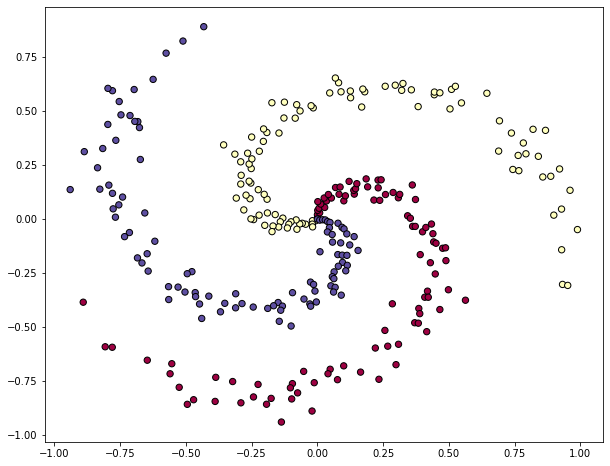

In [31]:
# generate data
N = 100
D = 2
K = 3
X = np.zeros((N * K, D))
y = np.zeros(N * K, dtype=np.uint8)
for j in range(K):
    ix = range(N * j, N * (j + 1))
    r = np.linspace(0.0, 1, N)
    t = np.linspace(j * 4, (j + 1) * 4, N) + np.random.randn(N) * 0.2
    X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
    y[ix] = j

plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral, edgecolors='k')
plt.show()

In [45]:
# train a 2-layer neural network
np.random.seed(0)

weight_scale = 0.01
hidden_size = 64
w1 = np.random.randn(D, hidden_size) * weight_scale
w2 = np.random.randn(hidden_size, K) * weight_scale
b1 = np.zeros(hidden_size)
b2 = np.zeros(K)

X_, w1_, w2_, b1_, b2_ = Value(X), Value(w1), Value(w2), Value(b1), Value(b2)

learning_rate = 1
iterations = 2000
print_every = 100
for i in range(iterations):
    h = (X_.mm(w1_) + b1_).relu()
    scores = h.mm(w2_) + b2_
    loss = scores.cross_entropy_loss(y)
    loss.zero_grad()
    loss.backward()
    for param in (w1_, w2_, b1_, b2_):
        param.value -= learning_rate * param.grad
    if i % print_every == 0:
        print('iteration %d, loss %.4f' % (i, loss.value))

iteration 0, loss 1.0987
iteration 100, loss 0.6726
iteration 200, loss 0.6869
iteration 300, loss 0.6156
iteration 400, loss 0.4540
iteration 500, loss 0.3074
iteration 600, loss 0.2214
iteration 700, loss 0.2025
iteration 800, loss 0.1601
iteration 900, loss 0.1452
iteration 1000, loss 0.1313
iteration 1100, loss 0.1310
iteration 1200, loss 0.1116
iteration 1300, loss 0.1165
iteration 1400, loss 0.1007
iteration 1500, loss 0.1002
iteration 1600, loss 0.0922
iteration 1700, loss 0.0857
iteration 1800, loss 0.0776
iteration 1900, loss 0.0868


In [46]:
# evaluate the neural network
w1, w2, b1, b2 = w1_.value, w2_.value, b1_.value, b2_.value
def predict(X):
    scores = np.fmax(X @ w1 + b1, 0) @ w2 + b2
    y_pred = np.argmax(scores, axis=1)
    return y_pred
y_pred = predict(X)
train_acc = np.mean(y == y_pred)
print('train accuracy: %.4f' % (train_acc,))

train accuracy: 0.9767


(-1.9395962686057775, 1.880403731394226)

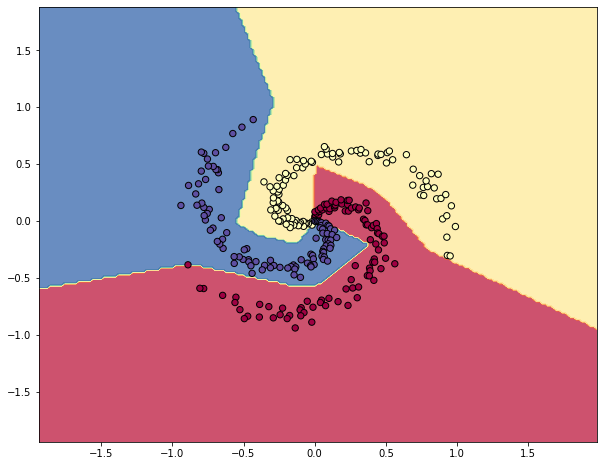

In [48]:
# plot the classifier (ref: cs231n lecture notes)
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral, edgecolors='k')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())